# Загрузка датасета и его разархировка

In [6]:
import shutil
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '//content//drive//MyDrive//Dataset//Classification_train_dataset.zip' -d './/'


# Создание обучающей выборки

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tt_split

In [10]:
df = pd.read_csv('.//full-gt.csv')
df.head()

,filename,x_from,y_from,width,height,sign_class,sign_id
0,autosave01_02_2012_09_13_33.jpg,649,376,18,18,2_1,0
1,autosave01_02_2012_09_13_34.jpg,671,356,20,21,2_1,0
2,autosave01_02_2012_09_13_35.jpg,711,332,27,26,2_1,0
3,autosave01_02_2012_09_13_36.jpg,764,290,37,36,2_1,0
4,autosave01_02_2012_09_13_36.jpg,684,384,17,17,1_23,1


### Удаление знаков из меток, которые присутствуют на малом количестве изображений

In [11]:
mc = df.sign_class.value_counts().sort_values()
unuseful_signs = np.array(mc[mc < 12].index)
index = df.sign_class.isin(unuseful_signs)
df = df[~index]

In [12]:
index_labels = df.sign_class.unique()
index_labels.sort()
len(index_labels)
dict_for_translate = {d: str(i) for i, d in enumerate(index_labels)}
df['sign_class'] = df.sign_class.map(dict_for_translate)

In [13]:
df.head()

,filename,x_from,y_from,width,height,sign_class,sign_id
0,autosave01_02_2012_09_13_33.jpg,649,376,18,18,29,0
1,autosave01_02_2012_09_13_34.jpg,671,356,20,21,29,0
2,autosave01_02_2012_09_13_35.jpg,711,332,27,26,29,0
3,autosave01_02_2012_09_13_36.jpg,764,290,37,36,29,0
4,autosave01_02_2012_09_13_36.jpg,684,384,17,17,19,1


In [14]:
train_df = df.groupby('filename', as_index=False)\
.agg({'sign_class': lambda x: '|'.join(sorted(set(x)))})[['filename', 'sign_class']]

### Разделение выборки на обучающую и тестовую

In [15]:
def train_test_split(data, test_size=0.2):
    value_count = pd.DataFrame(data.sign_class.value_counts()).rename({'sign_class': 'n_count'}, axis=1)
    data = data.merge(value_count, left_on='sign_class', right_index=True)
    index = data.n_count > 100
    X_mc = data[index]
    X_nmc = data[~index]
    X_train, X_test = tt_split(X_mc, test_size=test_size, stratify=X_mc.sign_class)
    return pd.concat((X_train, X_nmc))[['filename', 'sign_class']], X_test[['filename', 'sign_class']]

In [16]:
X_train, X_test = train_test_split(train_df)

In [17]:
size_train = X_train.shape[0]
size_test = X_test.shape[0]
size = {'train': size_train, 'val': size_test}

In [18]:
X_train.to_csv('train.csv', index=False)
X_test.to_csv('test.csv', index=False)

### Создание объекта Dataset и DataLoader

In [19]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [20]:
class DatasetSigns(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, *, n_class):
        self.data_frame = pd.read_csv(csv_file)
        self.data_frame['sign_class'] = self.data_frame.sign_class.\
        apply(lambda x: list(map(int, x.split('|'))))
        self.root_dir = root_dir
        self.transform = transform
        self.n_class = n_class

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = torch.zeros(self.n_class)
        label[self.data_frame.iloc[idx, 1]] = 1
        
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [21]:
transform_sign_train = transforms.Compose([
     transforms.Resize(260),
     transforms.ToTensor(),
     transforms.ColorJitter(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
     ])

transform_sign_test = transforms.Compose([
      transforms.Resize(260),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                ])


train_dataset = DatasetSigns(csv_file='.//train.csv',root_dir='.//Classification_train_dataset', transform=transform_sign_train, n_class=158)
test_dataset = DatasetSigns(csv_file='.//test.csv',root_dir='.//Classification_train_dataset', transform=transform_sign_test, n_class=158)

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=0)
loader = {'train': train_loader, 'val': test_loader}

In [22]:
def tensor_imshow(img, title=None, plt_ax=plt, default=False):
    '''Imshow for tensor'''
    img = img.numpy().transpose((1, 2, 0))
    img = np.array([0.247, 0.243, 0.261]) * img + np.array([0.4914, 0.4822, 0.4465])
    img = np.clip(img, 0, 1)
    plt_ax.imshow(img)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

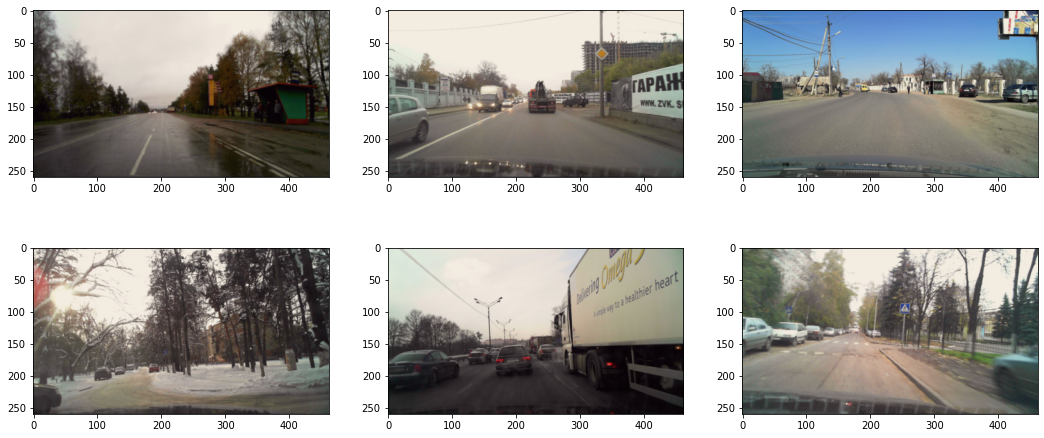

In [23]:
batch = next(iter(loader['val']))
plt.figure(figsize=(18, 8))
for i in range(3):
    plt.subplot(2, 3, i+1)
    # plt.axis("off")
    tensor_imshow(batch[0][i])
    plt.subplot(2, 3, i+4)
    # plt.axis("off")
    tensor_imshow(batch[0][i+4])
plt.show();

# Обучение модели MobileNet V2 на данных

In [24]:
import copy
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [27]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if device == 'cuda:0':
    model.cuda()

In [20]:
def train_model(model, dataloader, size, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
    # best_model_wts = copy.deepcopy(model.state_dict())  
    best_acc = 0.0
    iteration = 0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        # train
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for data in dataloader['train']:
            iteration += 1
            if not iteration % 100:
                print(iteration * 50, '; Loss: ', running_loss, '; Acc: ', running_corrects)
            inputs = data[0].to(device)
            labels = data[1].to(device)

            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.all((outputs > 0.5).type(torch.float).to('cpu') == labels.to('cpu')).double()

            scheduler.step()

        epoch_loss = running_loss / size['train']
        epoch_acc = running_corrects / size['train']
        print(f'TRAIN Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
        # test
        running_loss = 0.0
        running_corrects = 0
        model.eval()
        
        for data in dataloader['val']:
            iteration += 1
            if not iteration % 100:
                print(iteration * 50, '; Loss: ', running_loss, '; Acc: ', running_corrects)
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.all((outputs > 0.5).type(torch.float).to('cpu') == labels.to('cpu')).double()
        
      
        epoch_loss = running_loss / size['val']
        epoch_acc = running_corrects / size['val']      
        print(f'VAL   Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print(f'Best val Acc: {best_acc:4f}')
    return model

In [134]:
#!L
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(in_features=1280, out_features=158, bias=True),
    torch.nn.Sigmoid()
    )
model = model.to('cpu')
model.load_state_dict(torch.load('.//MobileNetV2_10epoch.pt', map_location=torch.device('cpu')))
freeze_layer = 8
for x in list(model.features.parameters())[:freeze_layer]:
    x.requires_grad = False
for x in list(model.features[freeze_layer:].parameters())[freeze_layer:]:
    x.requires_grad = True
for x in model.classifier.parameters():
    x.requires_grad = True

if device == 'cuda:0':
    model.cuda()

In [23]:
optimizer = torch.optim.Adam(list(model.features.parameters())[freeze_layer:] + list(model.classifier.parameters()), lr=0.0001)
loss_fn = torch.nn.BCELoss()
exp_lr_sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1270, gamma=0.1)

In [37]:
best_model1 = train_model(model, loader, size, loss_fn, optimizer, exp_lr_sheduler, num_epochs=10, device=device)

Epoch 1/10
----------
5000 ; Loss:  111.98518816381693 ; Acc:  tensor(0., dtype=torch.float64)
10000 ; Loss:  223.45330147072673 ; Acc:  tensor(0., dtype=torch.float64)
15000 ; Loss:  333.56894459575415 ; Acc:  tensor(0., dtype=torch.float64)
20000 ; Loss:  445.25085925124586 ; Acc:  tensor(0., dtype=torch.float64)
25000 ; Loss:  555.810302356258 ; Acc:  tensor(0., dtype=torch.float64)
30000 ; Loss:  663.5175640694797 ; Acc:  tensor(0., dtype=torch.float64)
35000 ; Loss:  772.9801109060645 ; Acc:  tensor(0., dtype=torch.float64)
40000 ; Loss:  882.0179282687604 ; Acc:  tensor(0., dtype=torch.float64)
45000 ; Loss:  989.4305352587253 ; Acc:  tensor(0., dtype=torch.float64)
50000 ; Loss:  1098.2721495442092 ; Acc:  tensor(0., dtype=torch.float64)
TRAIN Loss: 0.0220 Acc: 0.0000
55000 ; Loss:  44.91659461054951 ; Acc:  tensor(0., dtype=torch.float64)
VAL   Loss: 0.0110 Acc: 0.0000
Epoch 2/10
----------
60000 ; Loss:  16.939587937667966 ; Acc:  tensor(0., dtype=torch.float64)
65000 ; Loss: 

In [38]:
PATH = './/MobileNetV2.pt'
torch.save(best_model1.state_dict(), PATH)

In [39]:
shutil.copy('.//MobileNetV2.pt', '//content//drive//MyDrive//Dataset//')

'//content//drive//MyDrive//Dataset//MobileNetV2.pt'

In [ ]:
model.load_state_dict(torch.load('.//MobileNetV2.pt', map_location=torch.device('cpu')))
model.to(device)

In [137]:
def Accuracy_model(model, dataloader, size):
    model.eval()
    correct = 0
    for data, label in dataloader['val']:
        data = data.to(device)
        predict = model(data).to('cpu') > 0.5
        correct += torch.sum(torch.all(predict.type(torch.float) == label, axis=1).type(torch.long))
    acc = correct / size['val']
    print(f'Accuracy on VAL  : {acc:.4f}')    
    correct = 0
    for data, label in dataloader['train']:
        data = data.to(device)
        label = label.to(device)
        predict = model(data)
        correct += torch.sum(torch.all(predict.type(torch.float) == label, axis=1).type(torch.long))
    acc = correct / size['train']
    print(f'Accuracy on TRAIN: {acc:.4f}')

In [33]:
Accuracy_model(model, loader, size)

Accuracy on VAL  : 0.5087


In [142]:
it = iter(loader['train'])
data, label = next(it)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ошибок:  tensor(1) Всего знаков на изображении: tensor(2.)


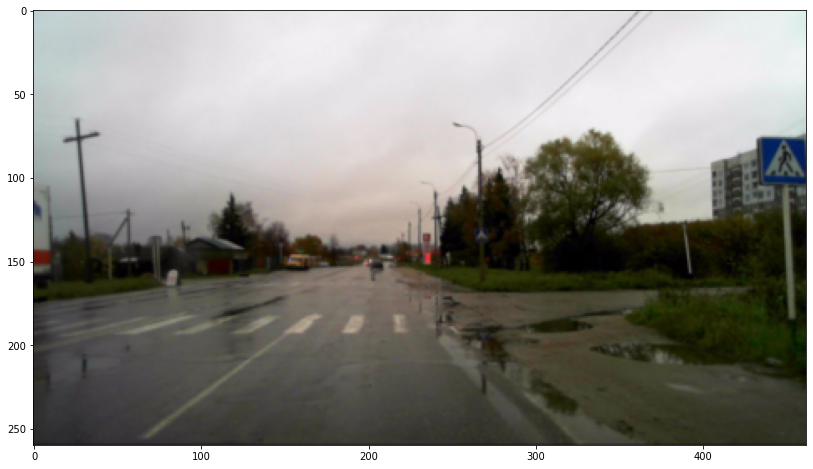

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ошибок:  tensor(1) Всего знаков на изображении: tensor(1.)


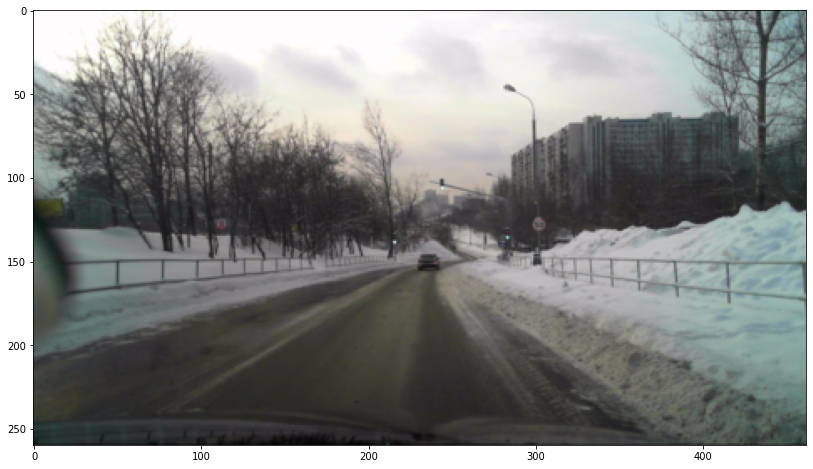

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ошибок:  tensor(2) Всего знаков на изображении: tensor(1.)


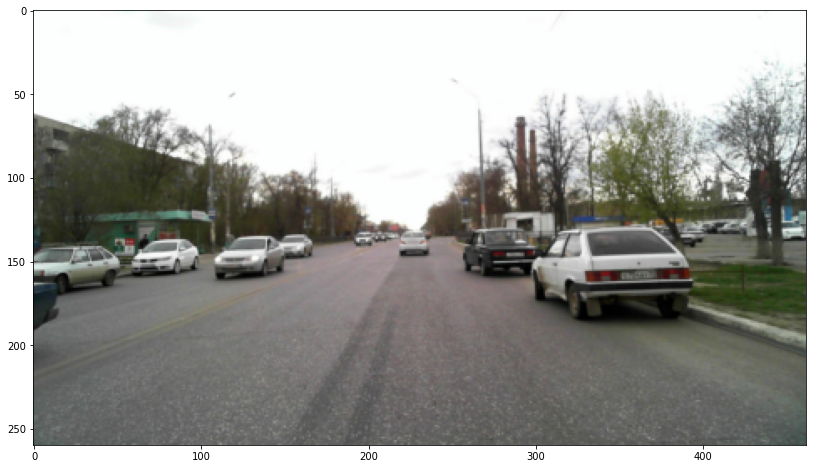

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ошибок:  tensor(1) Всего знаков на изображении: tensor(1.)


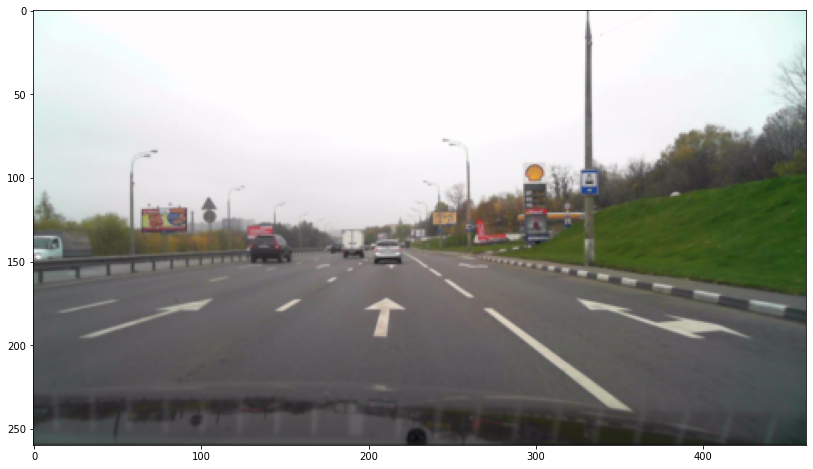

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ошибок:  tensor(2) Всего знаков на изображении: tensor(1.)


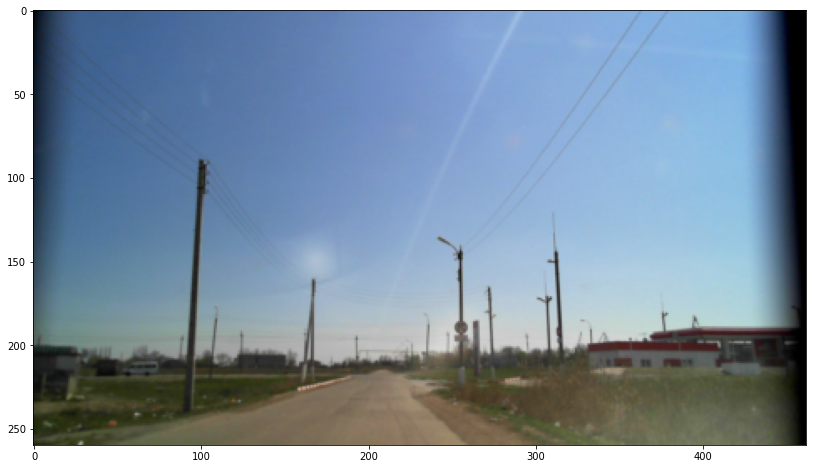

In [143]:
max_imag = 5
count = 0
for i in range(50):
    predict = (model(data[i:i+1]).to('cpu') > 0.5).type(torch.float)
    right = torch.all(predict == label[i]).type(torch.long)
    if right == torch.tensor(0) and count < max_imag:
        count += 1
        img = np.array([0.247, 0.243, 0.261]) * data[i].numpy().transpose((1, 2, 0)) + np.array([0.4914, 0.4822, 0.4465])
        plt.figure(figsize=(18, 8))
        plt.imshow(img)
        print('Ошибок: ', torch.sum(~(predict == label[i])), 'Всего знаков на изображении:', torch.sum(label[i]))
        plt.show();

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [46]:
predict = predict.to('cpu')

In [47]:
torch.all(predict.type(torch.float)[1] == label[1]).type(torch.long)

tensor(1)

In [51]:
torch.all(torch.tensor([[True, False],
                        [True, True]]), axis=1)

tensor([False,  True])